<a href="https://colab.research.google.com/github/anslemhuncho/MACHINE-LEARNING-PROJECT/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Trial 5 Complete [00h 07m 36s]
val_accuracy: 0.3230035901069641

Best val_accuracy So Far: 0.37425506114959717
Total elapsed time: 01h 03m 17s
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7fbd001339d0>
Epoch 1/25
106/106 [==============================] - 45s 408ms/step - loss: 1.6249 - accuracy: 0.4319 - val_loss: 1.8871 - val_accuracy: 0.3564
Epoch 2/25
106/106 [==============================] - 40s 381ms/step - loss: 1.5469 - accuracy: 0.4630 - val_loss: 1.9143 - val_accuracy: 0.3504
Epoch 3/25
106/106 [==============================] - 41s 385ms/step - loss: 1.4650 - accuracy: 0.4911 - val_loss: 1.9264 - val_accuracy: 0.3528
Epoch 4/25
106/106 [==============================] - 41s 387ms/step - loss: 1.4301 - accuracy: 0.5181 - val_loss: 1.9489 - val_accuracy: 0.3540
Epoch 5/25
106/106 [==============================] - 42s 393ms/step - loss: 1.3933 - accuracy: 0.5166 - val_loss: 1.9661 - val_accuracy: 0.3564
Epoch 6/25
1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


65/65 [==============================] - 618s 10s/step - loss: 0.9022 - accuracy: 0.7463
Test Metrics: [0.9021549224853516, 0.7462542057037354]
Test Loss: 0.9021549224853516
Test Accuracy: 0.7462542057037354


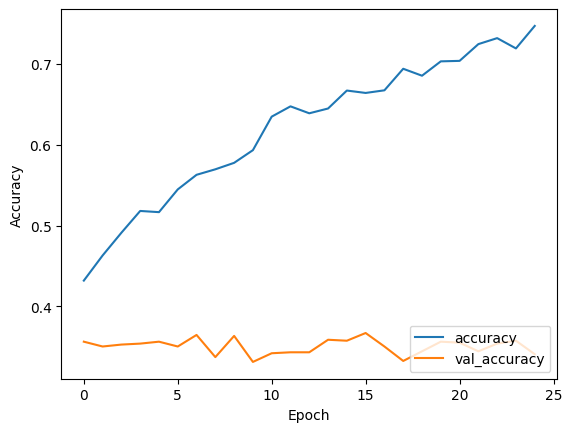

In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import matplotlib.pyplot as plt
from datetime import datetime


# Define paths to your train and test folders in Google Drive
train_path = '/content/drive/MyDrive/Normalised data/train'  # Use all data for training
test_path = '/content/drive/MyDrive/Normalised data/test'

# Manually specify class labels and their indices
class_labels = {
    0: 'animals_protection',
    1: 'appealing_for_peace',
    2: 'brexit',
    3: 'covid19',
    4: 'election',
    5: 'environment_protection',
    6: 'gender_equality',
    7: 'immigration',
    8: 'racial_equality',
    9: 'yellow_vests_movement'
}

# Create ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split 20% of data for validation
)

# Adjust batch size based on your system's memory
batch_size = 32  # Experiment with different batch sizes
target_size = (150, 150)  # Reduce image size for faster processing

# Generate batches of augmented data from train folder with validation split
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_labels.values(),
    shuffle=True,
    subset='training'  # Specify subset as training for train data
)

val_generator = datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_labels.values(),
    shuffle=False,
    subset='validation'  # Specify subset as validation for validation data
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_labels.values(),
    shuffle=False
)

# Define the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))

# Build your model on top of the VGG16 base model
def build_model(hp):
    model = Sequential([
        base_model,
        Flatten(),
        Dense(hp.Int('units', min_value=32, max_value=256, step=32), activation='relu'),
        Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)),
        Dense(len(class_labels), activation='softmax')
    ])

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Initialize the tuner (RandomSearch in this case)
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Adjust the number of trials as needed
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='vgg16_tuning'
)

# Perform hyperparameter tuning
tuner.search(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

# Get the best model and its hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f'Best Hyperparameters: {best_hyperparameters}')

# Train the best model
history = best_model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

# Save the trained model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"best_vgg16_model_{timestamp}.h5"  # You can customize the filename
best_model.save(model_name)
print(f"Saved the trained VGG16 model as {model_name}")

# Evaluate the best model on the test data
test_metrics = best_model.evaluate(test_generator)
print(f'Test Metrics: {test_metrics}')

# Unpack and print specific metrics if needed
test_loss = test_metrics[0]
test_accuracy = test_metrics[1]
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


65/65 [==============================] - 14s 212ms/step
Confusion Matrix:
[[202  44   5   4   3  14   1   1   2   6]
 [  8 252  10   1   3   4   1   2   0   6]
 [  8  10 243   2   6   4   0   1   1  10]
 [  3  11   9  99   5   5   0   2   4   5]
 [  6  17  14   3 157   5   0   4   4   6]
 [ 11  22   6   3   4 133   1   2   4   7]
 [  6  12   2   2   1   8 101   1   3  10]
 [ 16  30   7   2   9  10   0 101   2   5]
 [  5  24   6   1   7   7   1   7  99   6]
 [  0   7   4   1   1   1   0   0   1 157]]
Accuracy: 0.7462542290961818
Precision: 0.7675007720636822
Recall: 0.7462542290961818
F1-score: 0.7456830978887258


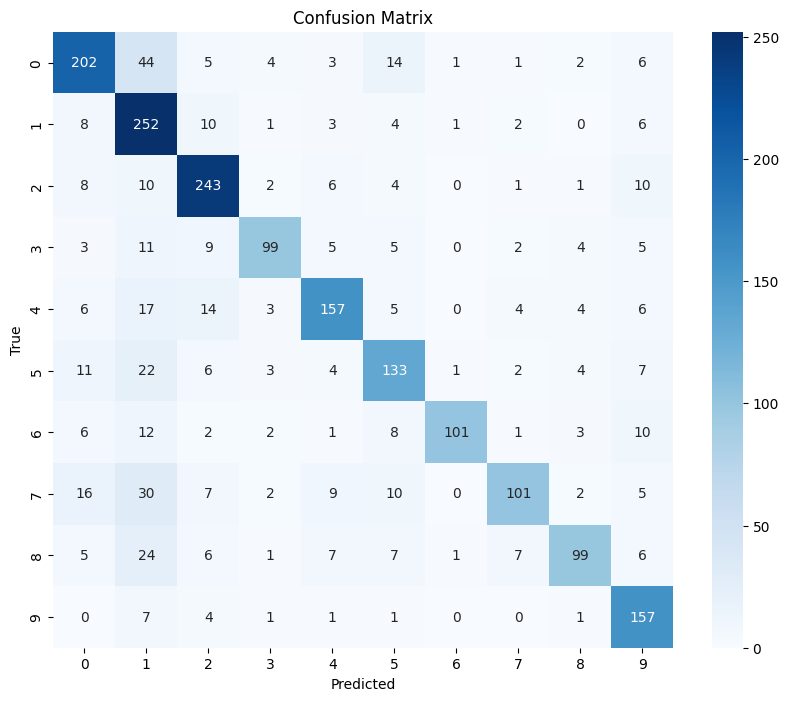

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get predictions from the model
predictions = best_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Collect true labels
true_classes = test_generator.classes

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate and print other evaluation metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")  # Save the confusion matrix as an image
plt.show()


In [7]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=114ad8a2f385b006c038949d99e7b31c3d0f27741505535c931d18f8395dbac6
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


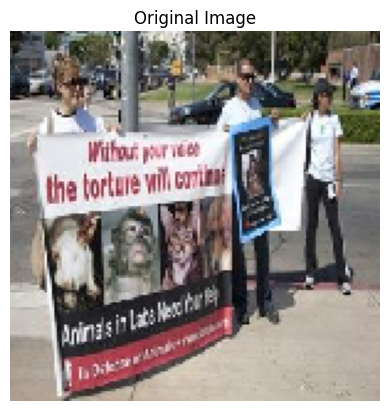

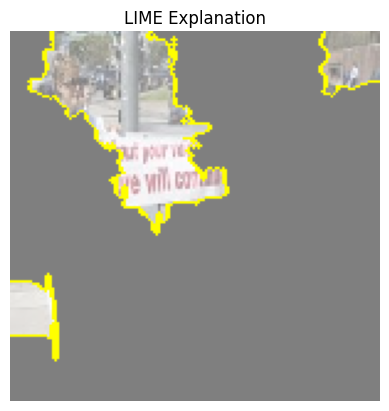

In [8]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Define a function to predict with the model
def predict_wrapper(images):
    return best_model.predict(images)

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Select an image for explanation (you can choose any image from your test data)
image_index = 0
image = test_generator[image_index][0][0]  # Assuming batch size is 1

# Explain the prediction
explanation = explainer.explain_instance(image.astype('double'), predict_wrapper, top_labels=5, hide_color=0, num_samples=1000)

# Show the original image
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')
plt.show()

# Show LIME explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.title('LIME Explanation')
plt.show()
